This notebook demostrates how to use ART on simulated data, where the response variable is modeled using a function with 'medium' level of difficulty.

## Setup

The first step is to make sure the `ART` library is available in your kernel.

Clone the corresponding git repository:


`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.



We can then add library to the path and do the necessary import:


In [1]:
import sys
sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
    
from art.core import *                                  


## User parameters

How many input variables (features) you would like to explore? Or what is the dimensionality of the system?

In [2]:
user_params = {'dim': 10}

Assign input and response variables:

In [3]:
input_var = ['x_' + str(i) for i in range(1, user_params['dim'] + 1)]
response_var = ['y']

Define the number instances for the initial DBTL cycle:

In [4]:
user_params['n_instances_cycle1'] = 100

Define the number of recommendations to be generated at each subsequent cycle:

In [5]:
user_params['num_recommendations'] = 16

Define the number of cycles you would like to perform:

In [6]:
user_params['n_cycles'] = 4

Define the exploitation-exploration parameter `alpha`. Values closer to 1 correspond to exploring regions of input phase space associated with high uncertainty, so as to obtain more data from that region and improve the model’s predictive accuracy in subsequent cycles. Values closer to 0 correspond to exploitation, i.e. optimizing the predicted value for the response variable.

In [7]:
user_params['alpha_cycle2'] = 0.9
user_params['alpha_cycle3'] = 0.5
user_params['alpha_cycle4'] = None

Define the objective for optimization and a threshold for defining success (for example, a success is 20% improvement over the best in the training data set)

In [8]:
user_params['objective'] = 'maximize'
user_params['threshold'] = 0.2

Define the output directory for storing the results and seed for random number generator for the repeatability of the run:

In [9]:
user_params['output_directory'] = '../results/'
user_params['seed'] = 42

## Define true response function

We define a function that will be used to simulate the true values of the response variable

In [10]:
def true_function_medium(x, dimension):

    f = 0.
    for i in range(dimension):
        f += x[i] ** 4 - 16 * x[i] ** 2 + 5 * x[i]

    f *= 1 / dimension
    return -1.*f

In [11]:
dim = user_params['dim']
global_optimum_value = 78.332                
global_optimum = -2.903534*np.ones(dim)
lb, ub = -5., 5.


### Visualize true function for 2-dimensional case

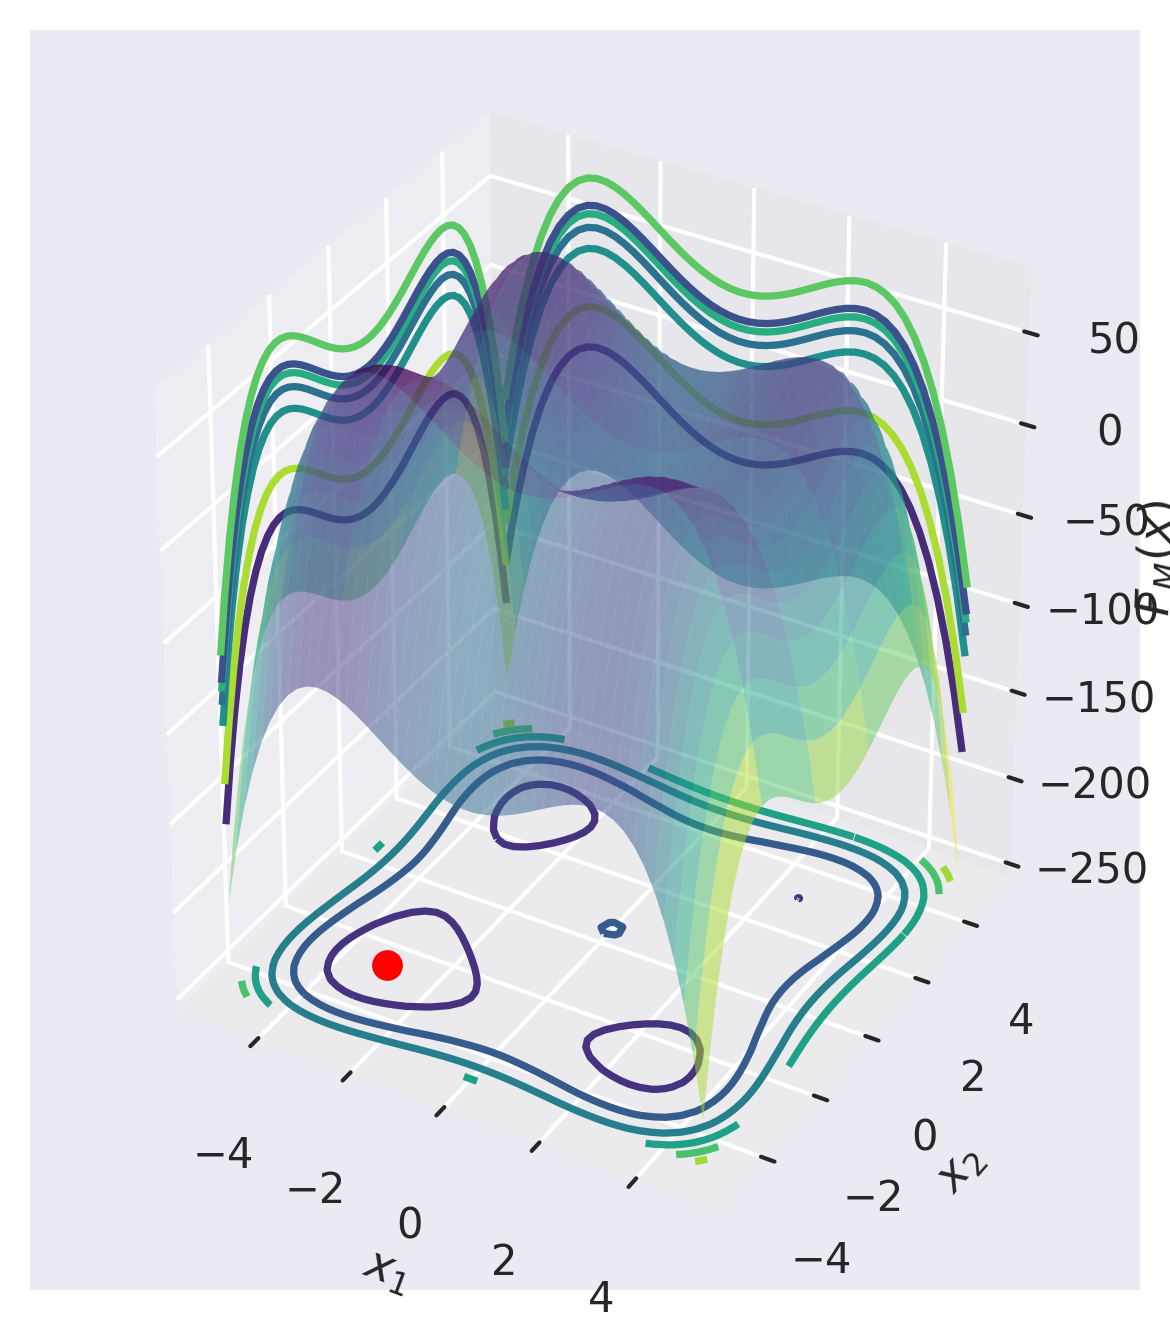

In [12]:
# Additional variables for plotting models
cmap = plt.cm.viridis_r 
n_points = 50
x1 = np.linspace(lb,ub,n_points)
x2 = np.linspace(lb,ub,n_points)
X, Y = np.meshgrid(x1, x2)
dimen = 2
Z = true_function_medium(np.array([X, Y]),dimen)
f_max = true_function_medium([-2.903534, -2.903534],dimen)
min_z = -250

fig = plt.figure(figsize=(4, 4.5), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, Y, Z, rstride=10, cstride=1, cmap=cmap, alpha=0.5,edgecolor='None')
ax.scatter(-2.903534, -2.903534, min_z, s=50, c='r',edgecolor='r')
ax.set_zlim3d(min_z, f_max)
cset = ax.contour(X, Y, Z, zdir='z', offset=min_z, cmap=cmap)
cset = ax.contour(X, Y, Z, zdir='x', offset=-5, cmap=cmap)
cset = ax.contour(X, Y, Z, zdir='y', offset=5, cmap=cmap)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$F_M(x)$')
plt.tight_layout()


## Create file with bounds for input variables

Here we define some constraints on the input variables, for example only positive values with an upper bound.

In [13]:
bounds_file = '../data/sim_data_bounds_FM.csv'

df = pd.DataFrame(columns=['Variable', 'Min', 'Max', 'Scaling'])
df['Variable'] = ['x_' + str(i) for i in range(1, dim + 1)]
df['Min'] = lb*np.ones(dim)
df['Max'] = ub*np.ones(dim)
df['Scaling'] = np.ones(dim)
df = df.set_index('Variable')
df.to_csv(path_or_buf=bounds_file)


## Cycle 1

In [14]:
cycle = 1

Initial designs for input variables are generated using ART’s feature for generating recommendations for the initial cycle, by setting its input parameter `initial_cycle` to True. This functionality of ART relies on the Latin Hypercube method (McKay et al., 1979), which spaces out draws in a way that ensures the set of samples represents the variability of the full design space. 

#### Define a dictionary that contains the settings for ART

In [15]:
art_params = {
    'bounds_file': bounds_file,
    'input_var': input_var,                       
    'num_recommendations': user_params['n_instances_cycle1'],    
    'initial_cycle': True,                                    # Set this to True for initial designs recommendations
    'seed': user_params['seed'],                              
    'output_directory': user_params['output_directory']  
}


#### Run ART

In [16]:
art = RecommendationEngine(**art_params)


Take a look at a few recommended designs for input variables:

In [17]:
art.recommendations.head()


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10
0,2.271472,2.717690,-1.828395,2.409442,-3.565735,-0.433822,2.464979,1.612596,-1.153602,-3.491773
1,0.132521,-4.641905,-1.209759,3.641483,4.187513,-2.239168,-2.651387,-1.142314,4.562565,1.485057
2,-2.160791,4.918528,-2.349872,-3.802466,-0.177955,2.279219,0.944211,4.359946,4.455469,2.472894
3,-2.933833,-1.898972,4.807116,4.343986,-2.482929,-1.472837,-1.034128,1.813097,-0.817645,-0.528525
4,2.300111,0.294676,2.150028,-3.773144,-3.818303,2.491840,4.855787,1.036107,1.040846,0.416302


Save simulated data into EDD-style files, to be used as training data for the next cycle:

In [18]:
X = art.recommendations.values
y = true_function_medium(X.T, dim).reshape(-1, 1)
training_data_file = f'../data/sim_data_FM_cycle{str(cycle + 1)}.csv'
utils.save_edd_csv(X, y, art.input_var, training_data_file)


## Cycle 2

In [19]:
cycle += 1

#### Define a dictionary that contains the settings for ART

In [20]:
art_params = {
    'bounds_file': bounds_file,
    'input_var': input_var,               
    'response_var': response_var,
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'alpha': user_params['alpha_cycle2'],
    'num_recommendations': user_params['num_recommendations'],  
    'seed': user_params['seed'],                           
    'output_directory': user_params['output_directory']  
}


Import training data file into a pandas dataframe:

In [21]:
df = utils.load_study(data_file=training_data_file)


#### Run ART

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


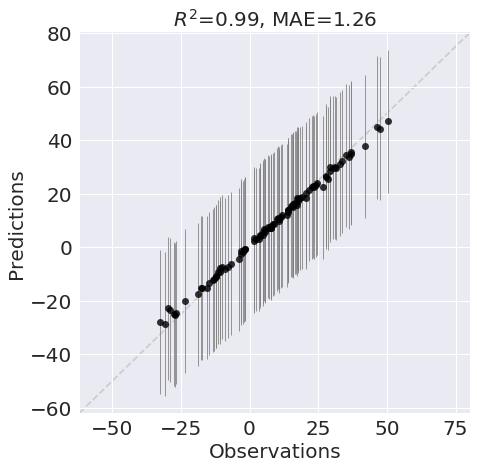

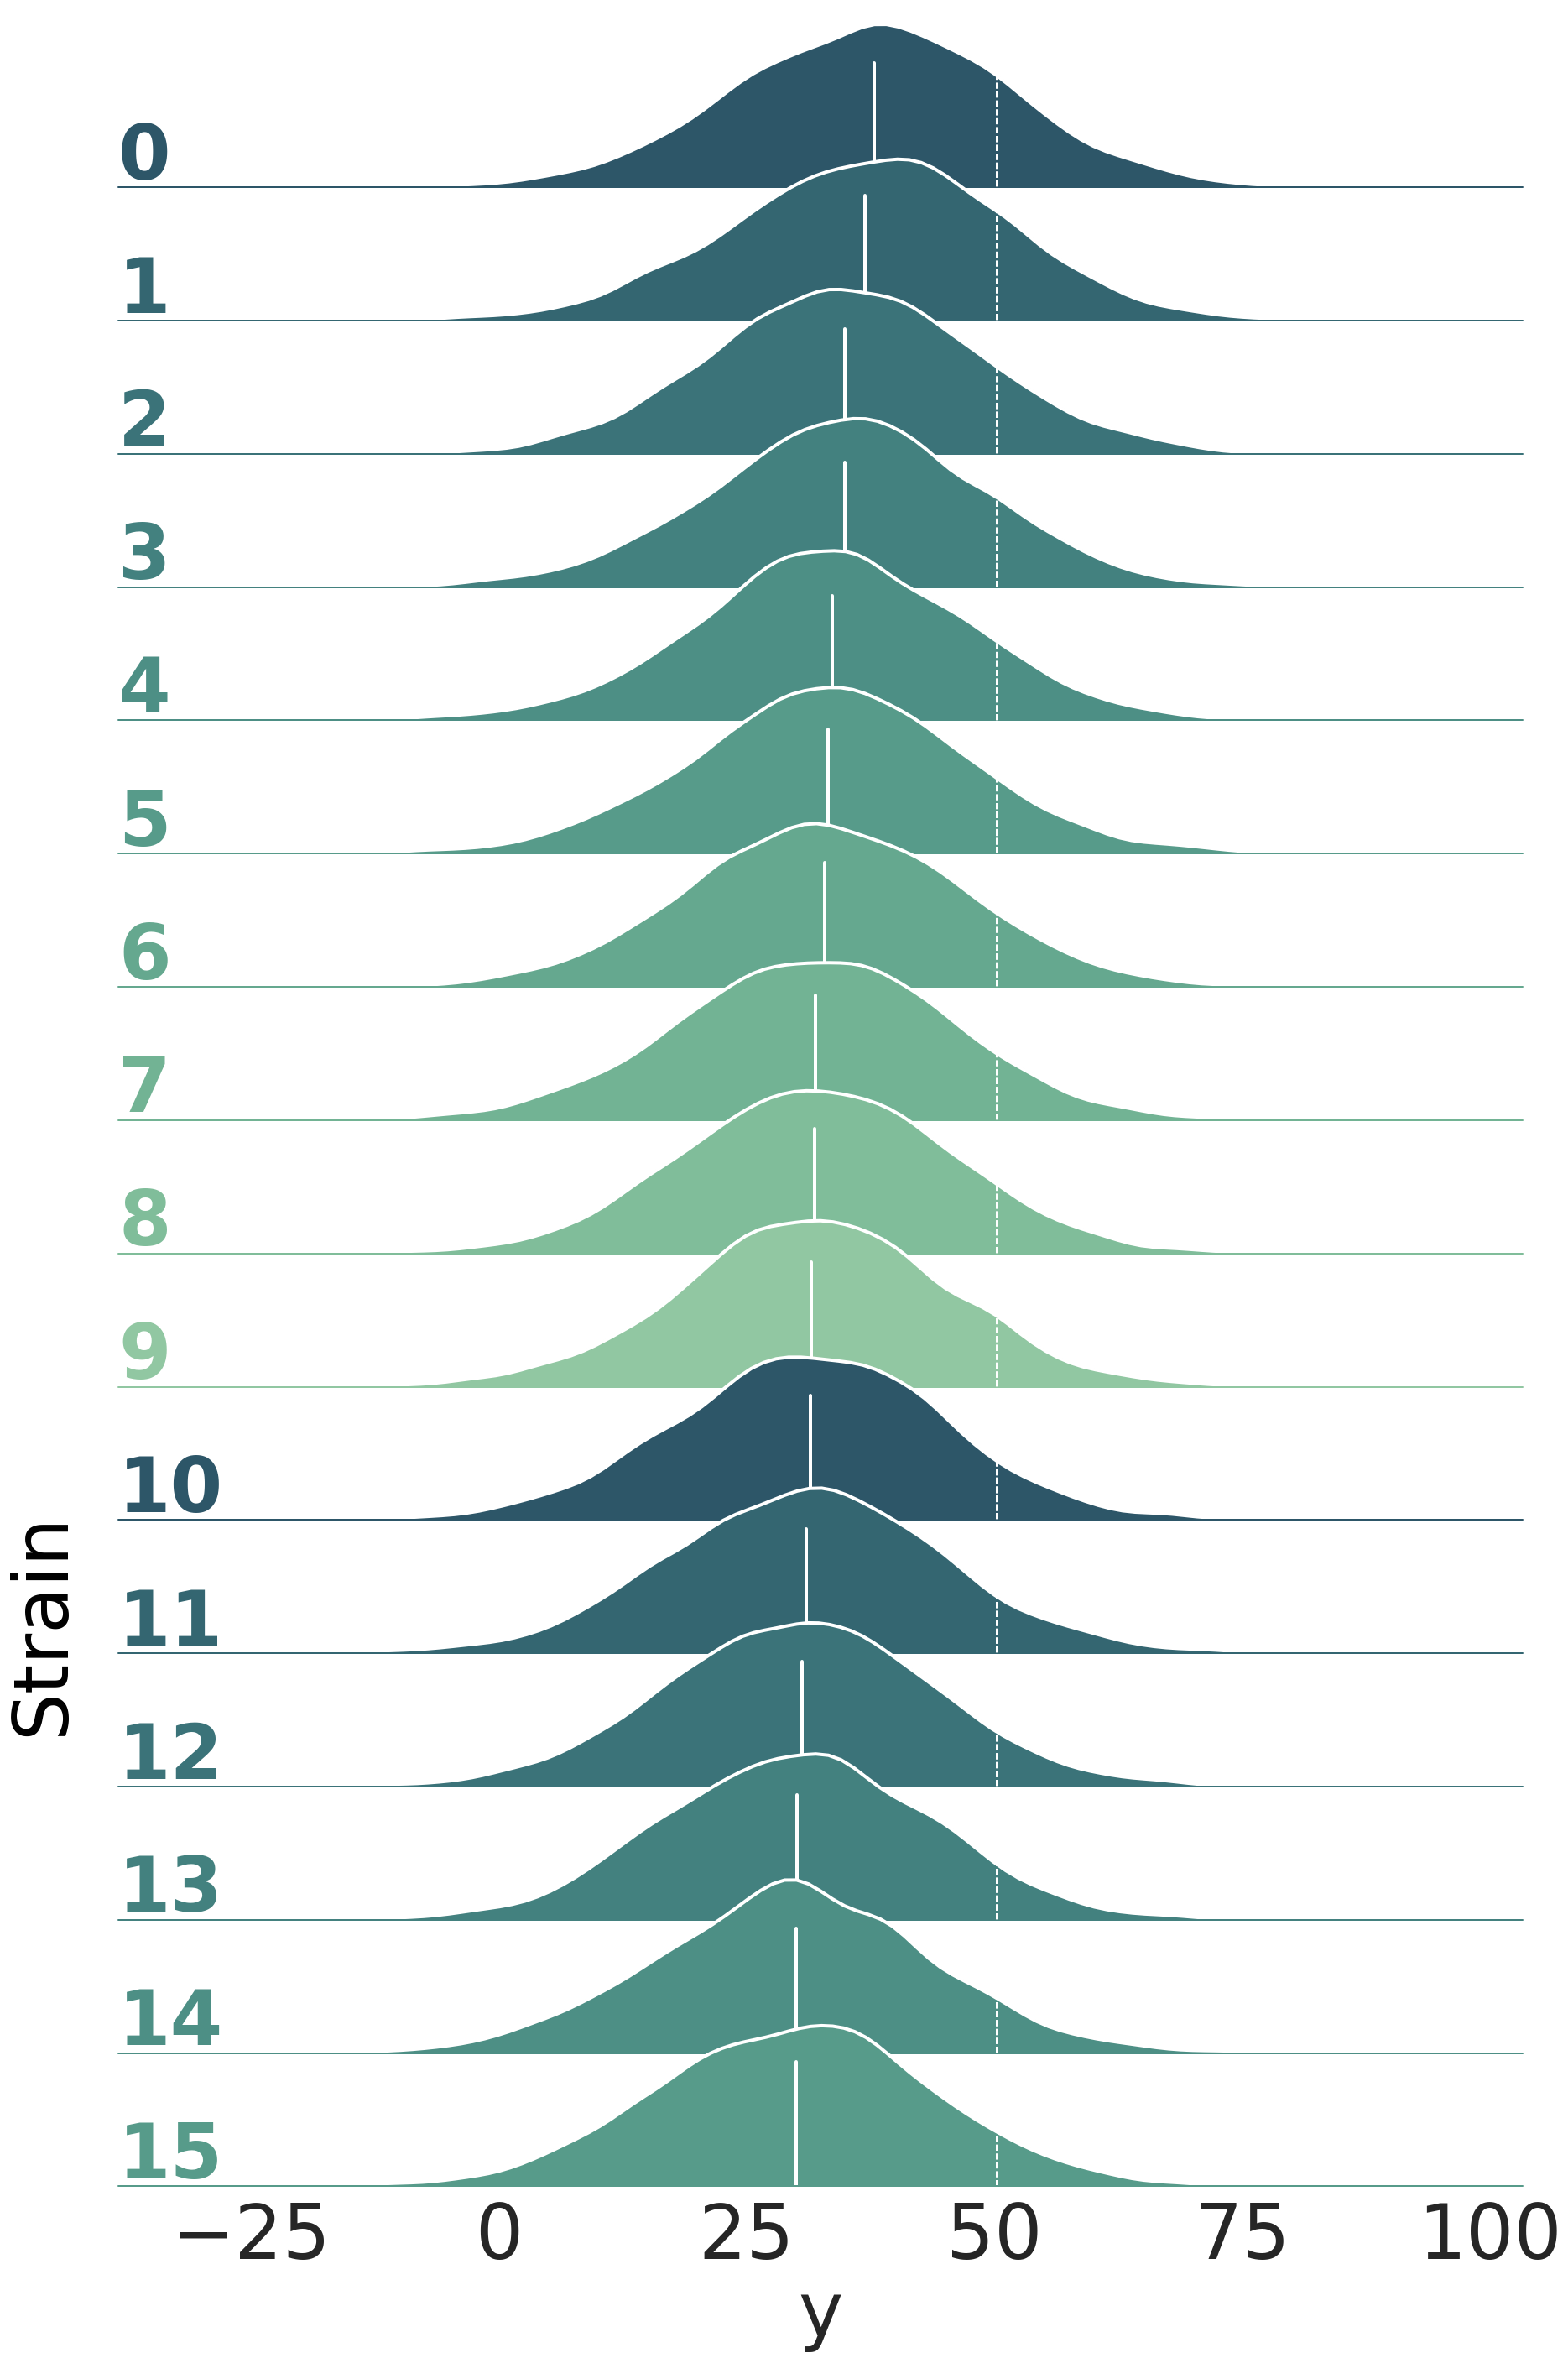

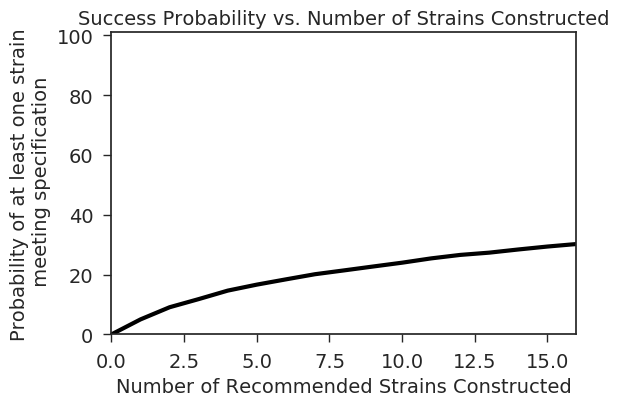

CPU times: user 4min 47s, sys: 1min 19s, total: 6min 6s
Wall time: 4min 49s


In [22]:
%%time
art = RecommendationEngine(df, **art_params)

Save recommendations for the next cycle:


In [23]:
file_path = f'{art.outDir}/recommendations_FM_cycle{str(cycle)}.csv'
art.recommendations.to_csv(path_or_buf=file_path, sep='\t')

#### Save training data for the next cycle

Input variables:

In [24]:
X_new = art.recommendations.values[:, :-1]


Simulate true values for the response variable using `true_function`:

In [25]:
y_new = true_function_medium(X_new.T, dim).reshape(-1, 1)


Save data in an EDD-style .csv file:

In [26]:
X = np.concatenate((art.X, X_new))
y = np.concatenate((art.y, y_new))
file_name = f'../data/sim_data_FM_cycle{str(cycle + 1)}.csv'
utils.save_edd_csv(X, y, art.input_var, file_name)


## Cycle 3

In [27]:
cycle += 1

#### Define a dictionary that contains the settings for ART

In [28]:
art_params = {
    'bounds_file': bounds_file,
    'input_var': input_var,               
    'response_var': response_var,
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'alpha': user_params['alpha_cycle3'],
    'num_recommendations': user_params['num_recommendations'],  
    'seed': user_params['seed'],                           
    'output_directory': user_params['output_directory']  
}


Import training data file into a pandas dataframe:

In [29]:
data_file = f'../data/sim_data_FM_cycle{str(cycle)}.csv'
df = utils.load_study(data_file=data_file)


#### Run ART

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


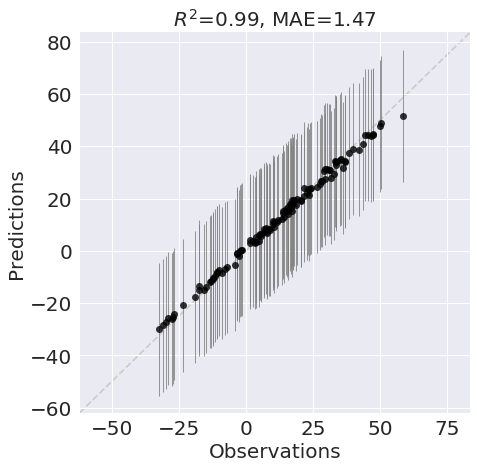

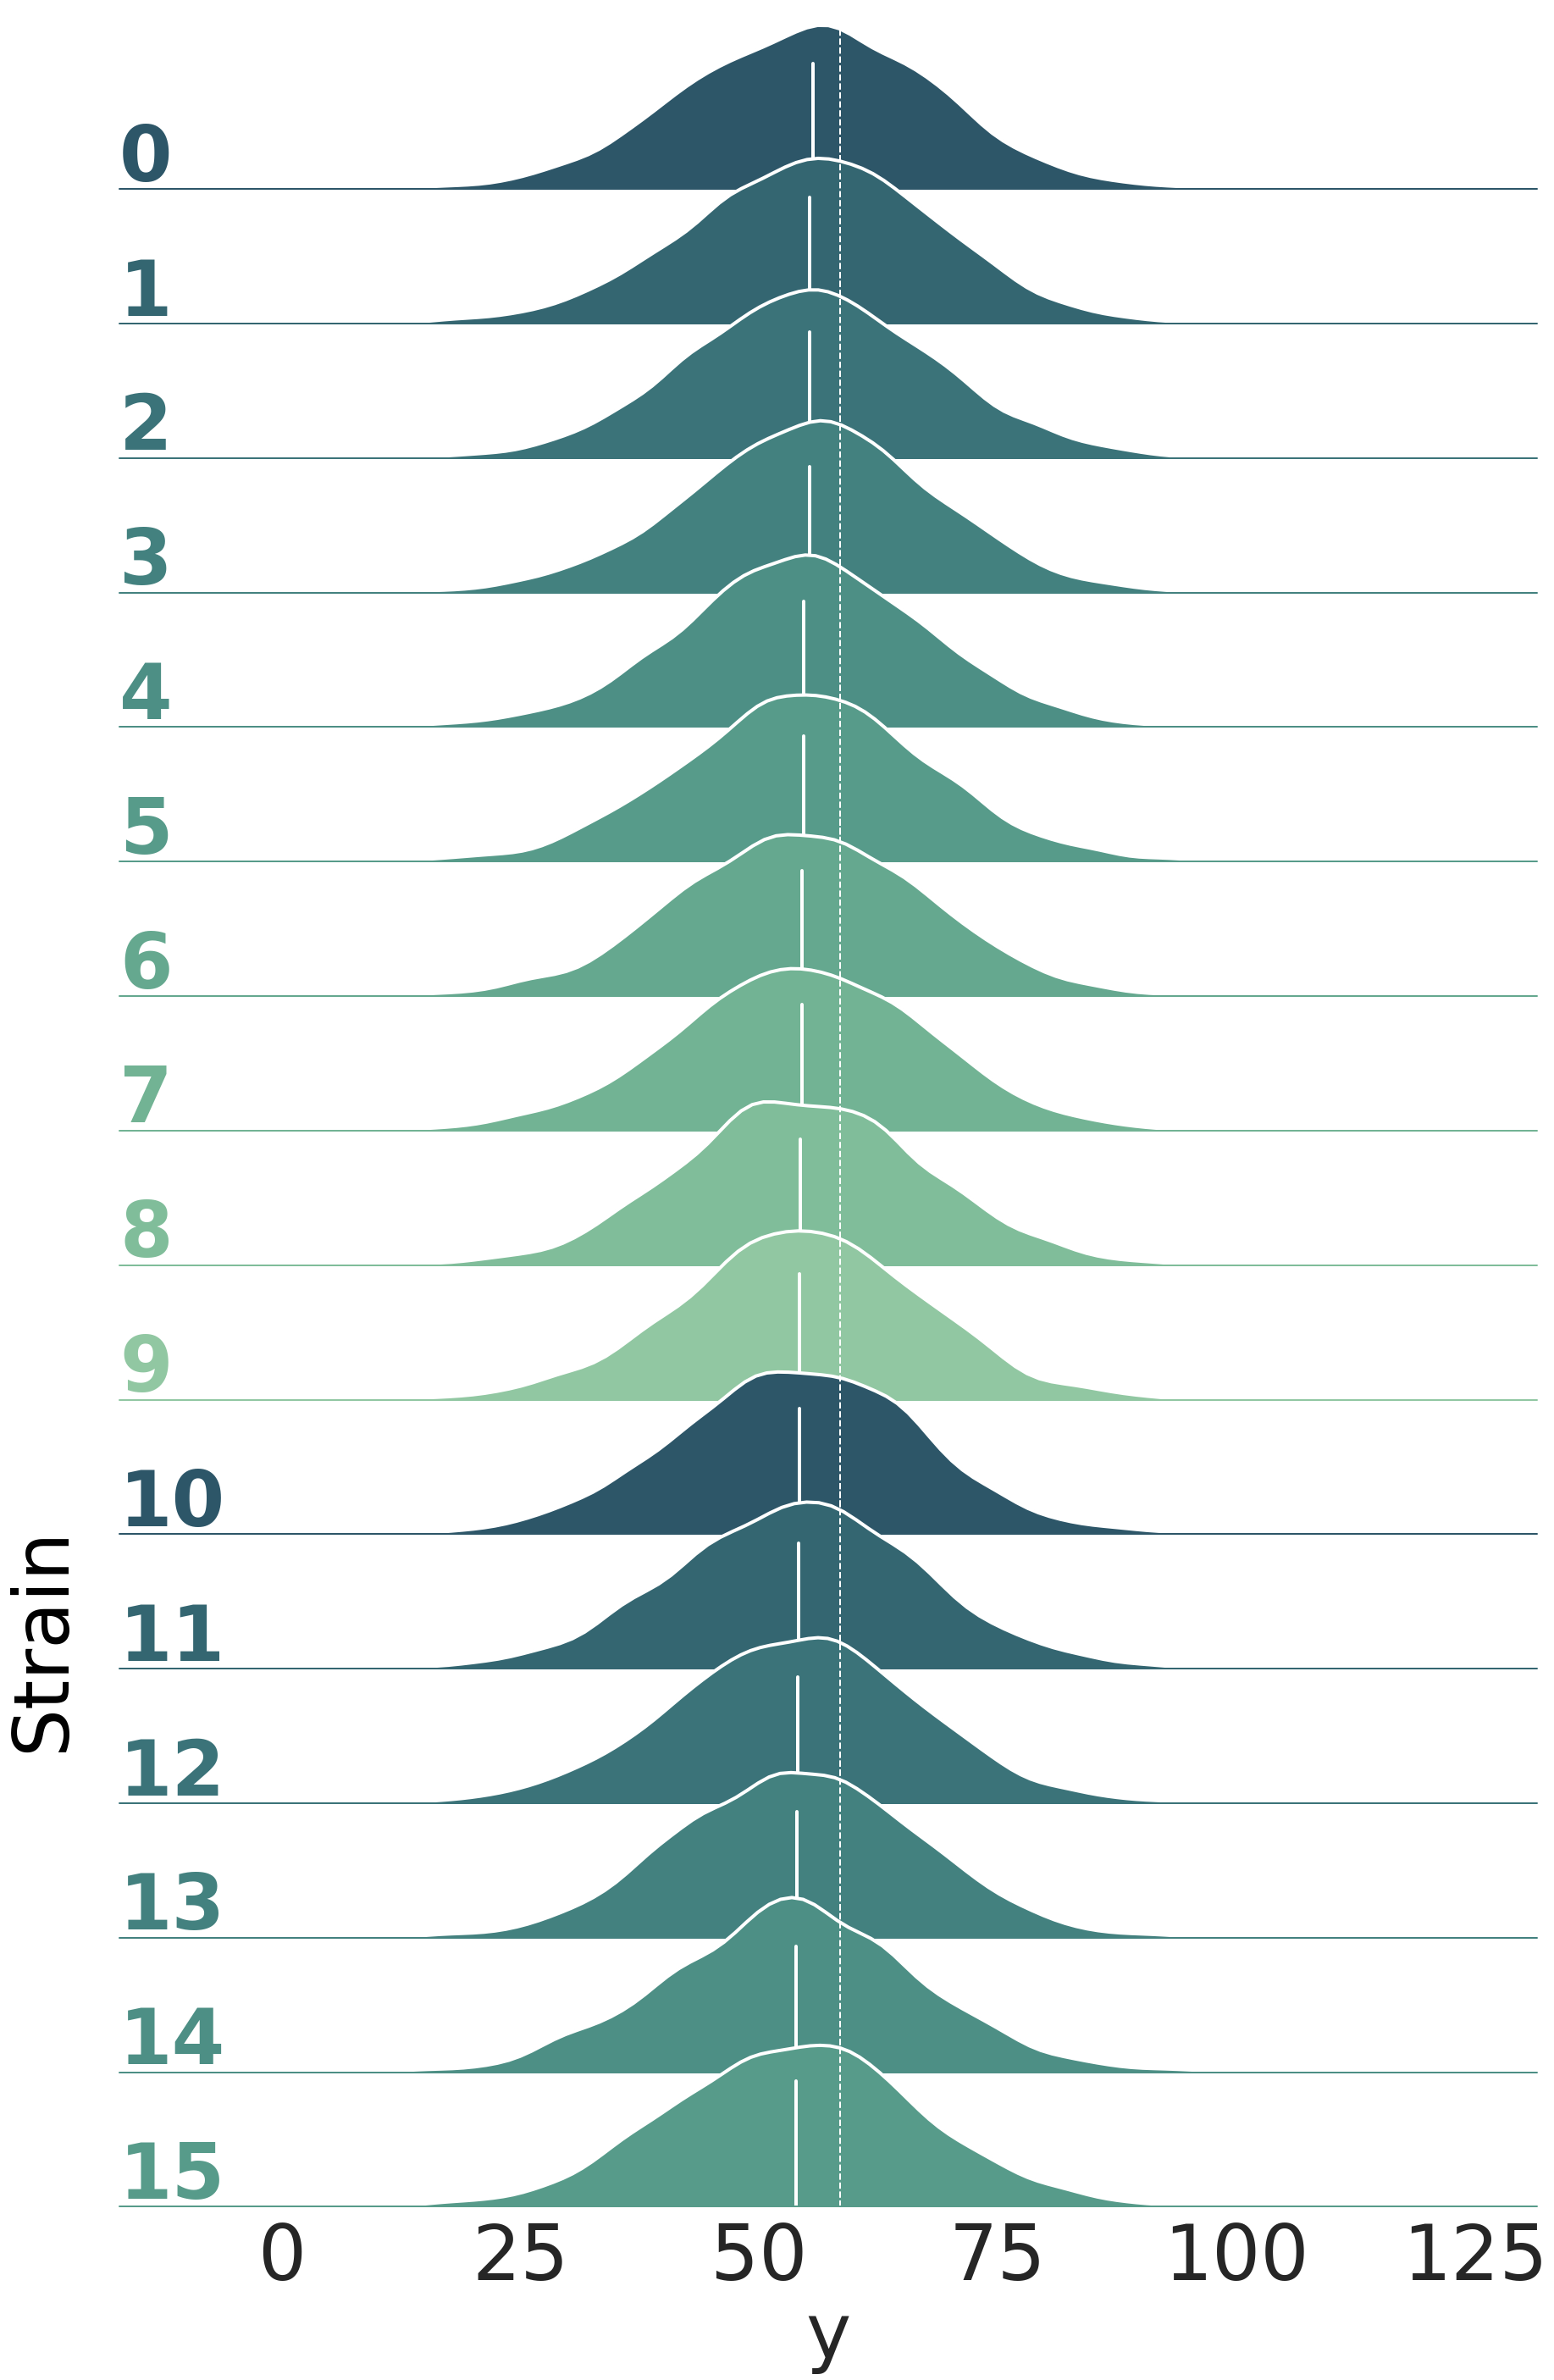

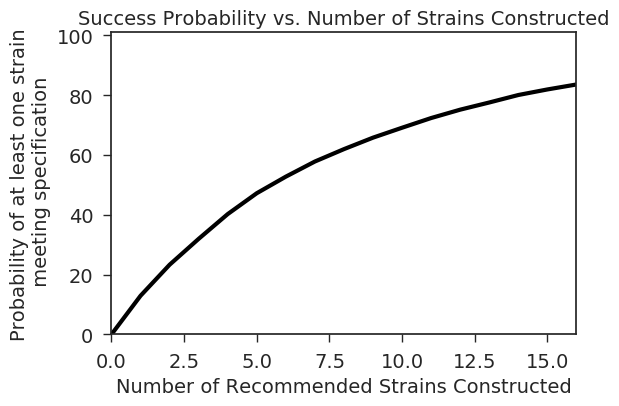

CPU times: user 5min 57s, sys: 1min 36s, total: 7min 33s
Wall time: 5min 40s


In [30]:
%%time
art = RecommendationEngine(df, **art_params)

Save recommendations for the next cycle:


In [31]:
file_path = f'{art.outDir}/recommendations_FM_cycle{str(cycle)}.csv'
art.recommendations.to_csv(path_or_buf=file_path, sep='\t')

#### Save training data for the next cycle

In [32]:
X_new = art.recommendations.values[:, :-1]
y_new = true_function_medium(X_new.T, dim).reshape(-1, 1)
X = np.concatenate((art.X, X_new))
y = np.concatenate((art.y, y_new))
file_name = f'../data/sim_data_FM_cycle{str(cycle + 1)}.csv'
utils.save_edd_csv(X, y, art.input_var, file_name)


## Cycle 4

In [33]:
cycle += 1

#### Define a dictionary that contains the settings for ART

In [34]:
art_params = {
    'bounds_file': bounds_file,
    'input_var': input_var,               
    'response_var': response_var,
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'alpha': user_params['alpha_cycle4'],
    'num_recommendations': user_params['num_recommendations'],  
    'seed': user_params['seed'],                           
    'output_directory': user_params['output_directory']  
}

Import training data file into a pandas dataframe:

In [35]:
data_file = f'../data/sim_data_FM_cycle{str(cycle)}.csv'
df = utils.load_study(data_file=data_file)

#### Run ART

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


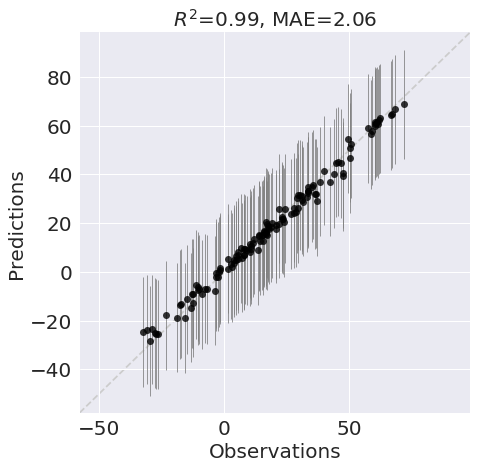

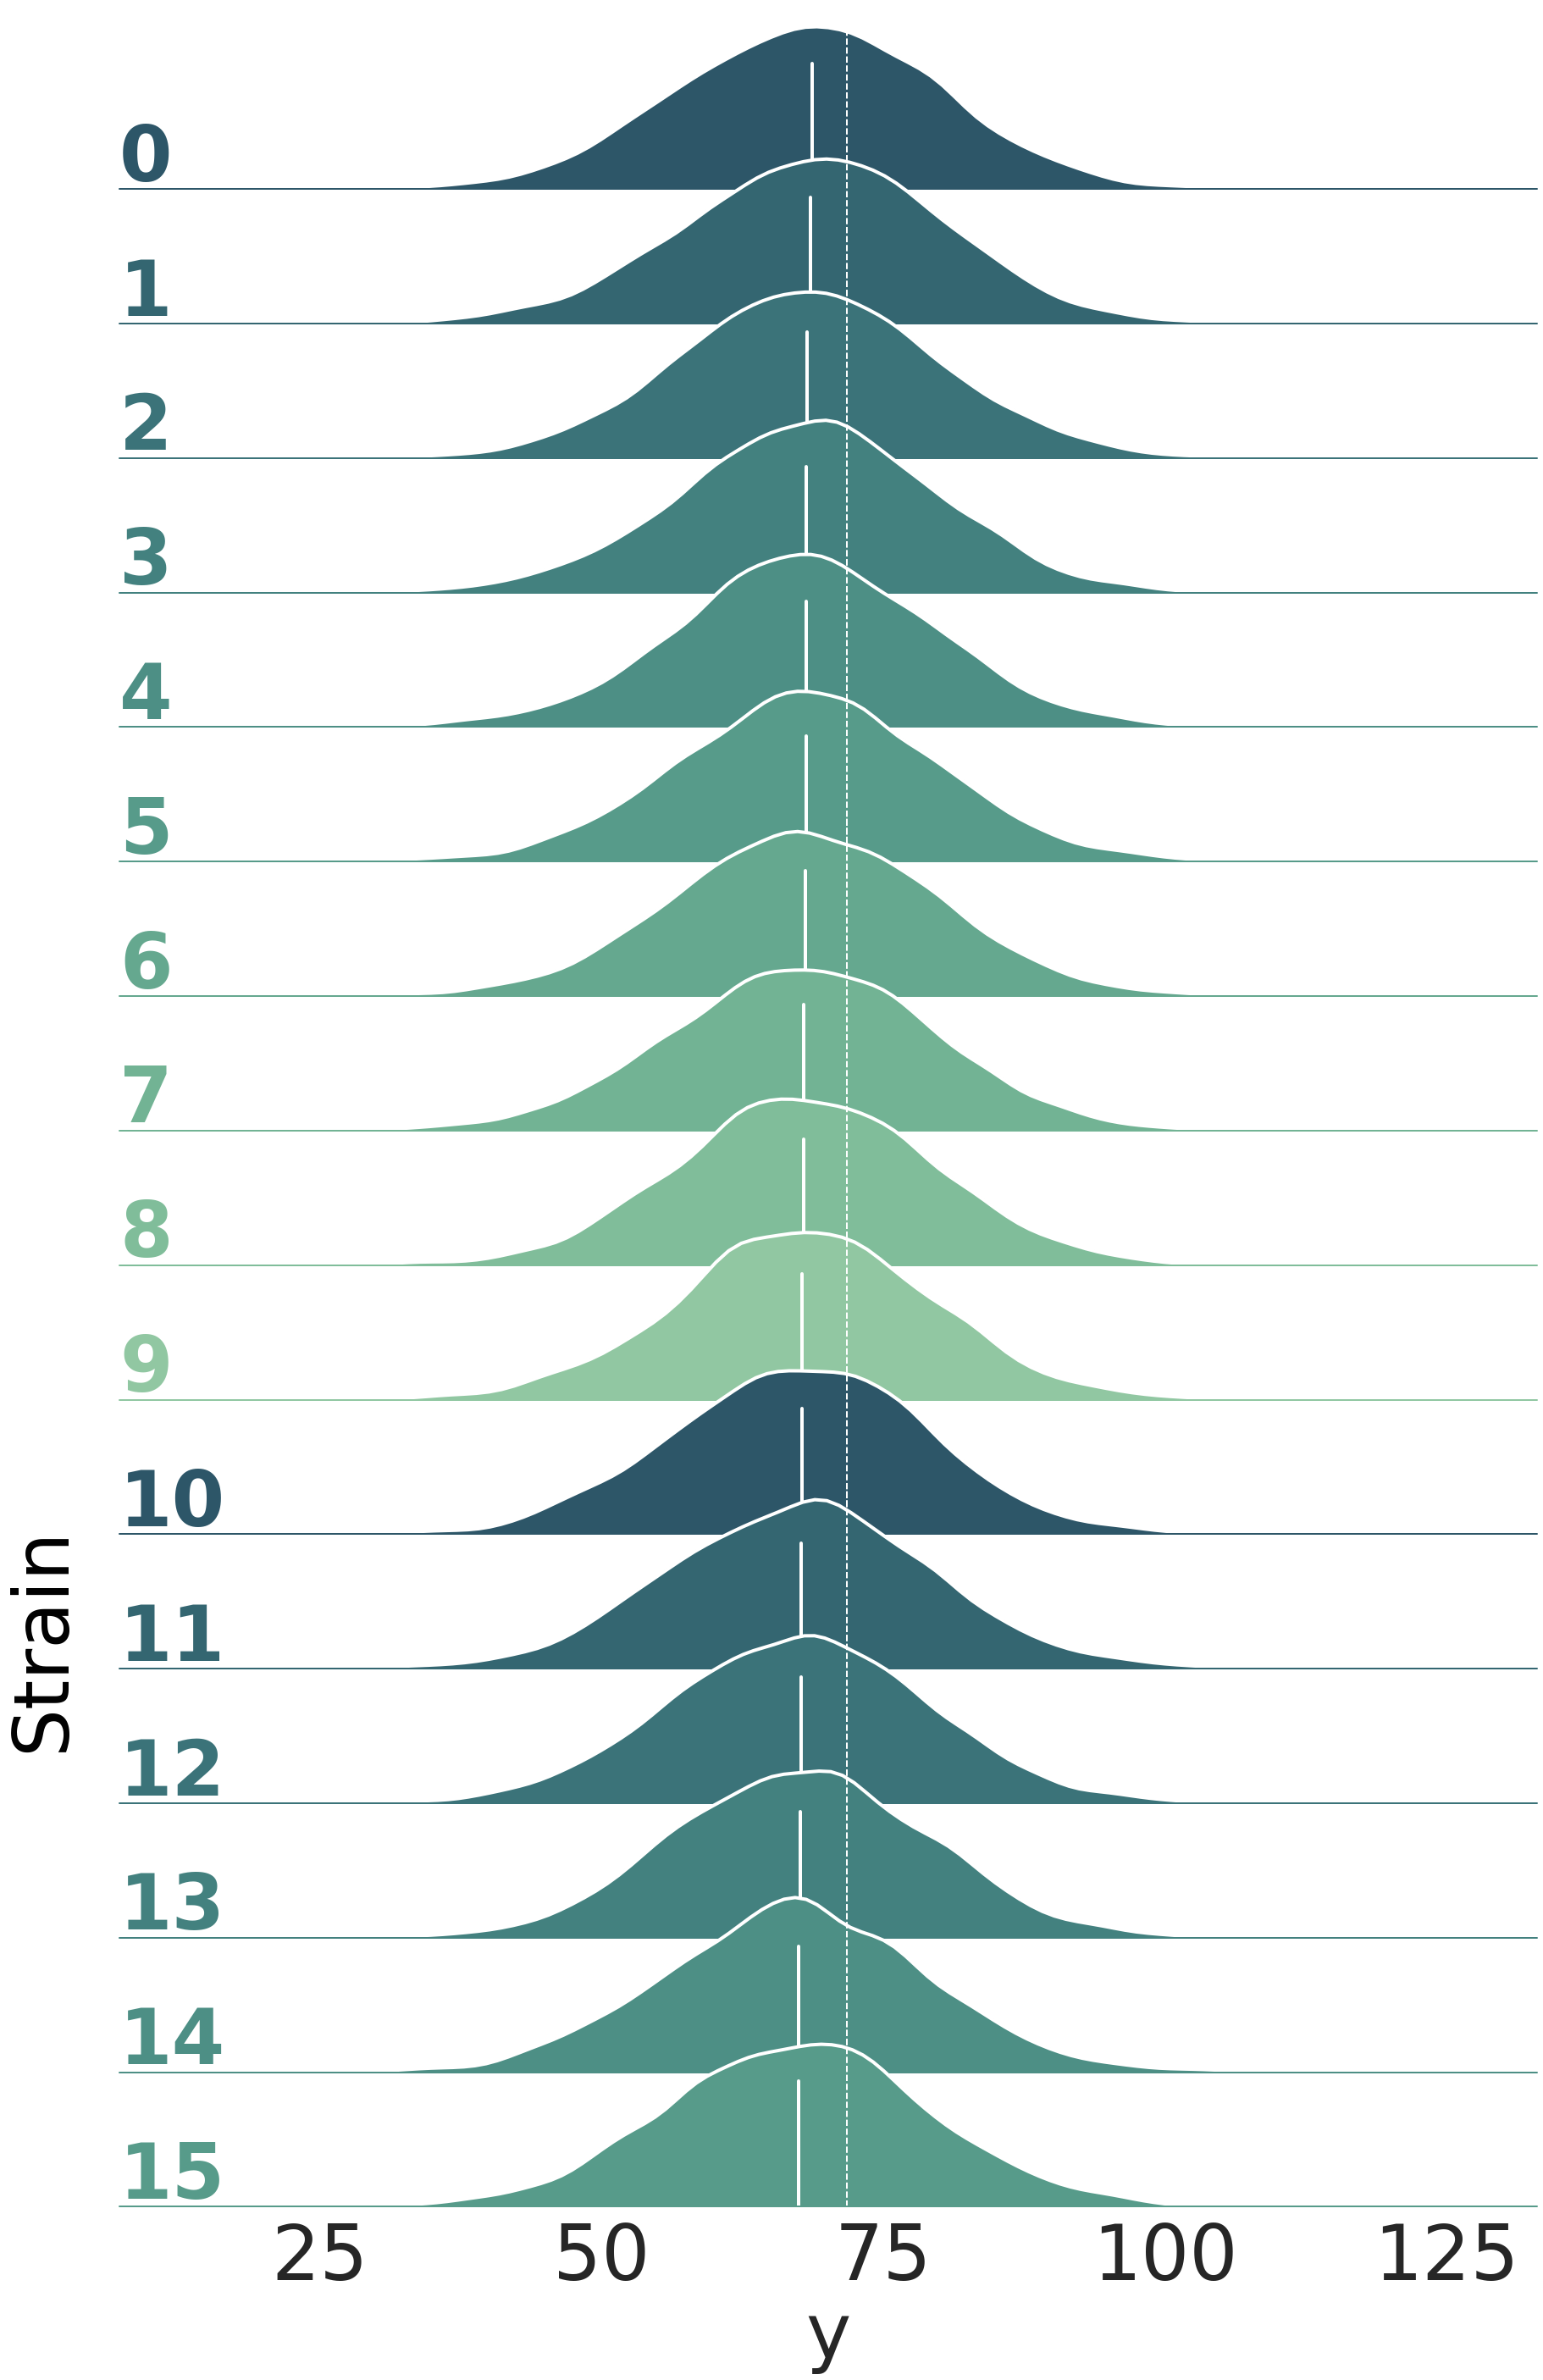

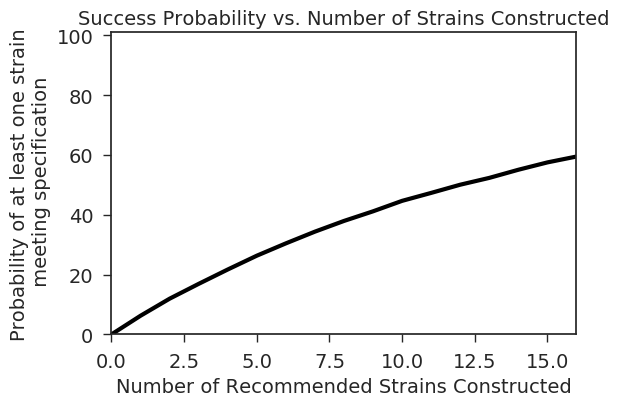

CPU times: user 7min 21s, sys: 1min 32s, total: 8min 54s
Wall time: 6min 28s


In [36]:
%%time
art = RecommendationEngine(df, **art_params)

Save recommendations for the next cycle


In [37]:
file_path = f'{art.outDir}/recommendations_FM_cycle{str(cycle)}.csv'
art.recommendations.to_csv(path_or_buf=file_path, sep='\t')